<h1> KF7006 Machine	Learning
    

<h1>Chest X-ray	classification	to	COVID-19,	Viral	Pneumonia,	normal

<h3>we have chest xray images dataset and we are going to classify into three catogries covid, pneumonia and normal

<h3>Importing Libraries for basic python preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from collections import Counter

<h4>Some Machine learning libraries 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Getting Data from directories 

In [3]:
train_data_dir = r"../input/covid19-image-dataset/Covid19-dataset/train"
test_data_dir = r"../input/covid19-image-dataset/Covid19-dataset/test"

In [4]:
covid_images = [os.path.join(train_data_dir, 'Covid', path) for path in os.listdir(train_data_dir + '/Covid')]
normal_images = [os.path.join(train_data_dir, 'Normal', path) for path in os.listdir(train_data_dir + '/Normal')]
viral_pneumonia_images = [os.path.join(train_data_dir, 'Viral Pneumonia', path) for path in os.listdir(train_data_dir + '/Viral Pneumonia')]

In [5]:
image = Image.open(covid_images[0])

Exploring Dataset

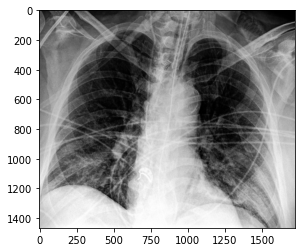

In [6]:
plt.imshow(np.array(image))
plt.show()

Normalization of the data

In [7]:

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

Creating our base model

In [8]:

img_width, img_height = 224, 224
batch_size = 8

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


total number of class

In [9]:

from collections import Counter
print("The individual class count in train set is ", Counter(train_generator.classes))
print("The individual class count in test set is ", Counter(test_generator.classes))

The individual class count in train set is  Counter({0: 111, 1: 70, 2: 70})
The individual class count in test set is  Counter({0: 26, 1: 20, 2: 20})


Implementation of Resnet model based on cnn

In [10]:

base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(3, activation='softmax')(global_avg_pooling)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

Epoch 1/10
32/32 [==============================] - 18s 415ms/step - loss: 0.9828 - accuracy: 0.4763 - val_loss: 2.3872 - val_accuracy: 0.3939
Epoch 2/10
32/32 [==============================] - 11s 333ms/step - loss: 0.1160 - accuracy: 0.9817 - val_loss: 1.7115 - val_accuracy: 0.3939
Epoch 3/10
32/32 [==============================] - 11s 347ms/step - loss: 0.0551 - accuracy: 0.9845 - val_loss: 1.4509 - val_accuracy: 0.3939
Epoch 4/10
32/32 [==============================] - 11s 337ms/step - loss: 0.0479 - accuracy: 0.9890 - val_loss: 1.4887 - val_accuracy: 0.3939
Epoch 5/10
32/32 [==============================] - 11s 333ms/step - loss: 0.0390 - accuracy: 0.9965 - val_loss: 1.5180 - val_accuracy: 0.3939
Epoch 6/10
32/32 [==============================] - 11s 352ms/step - loss: 0.0287 - accuracy: 0.9965 - val_loss: 1.4852 - val_accuracy: 0.3939
Epoch 7/10
32/32 [==============================] - 11s 332ms/step - loss: 0.0472 - accuracy: 0.9934 - val_loss: 1.2629 - val_accuracy: 0.2879

calculate Error rate in term of loss 

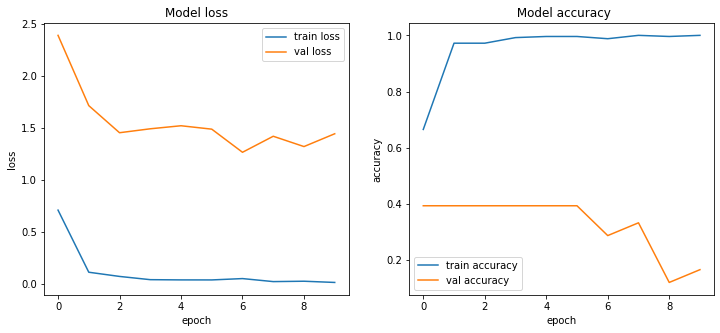

In [12]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), history.history['loss'], label='train loss')
plt.plot(range(10), history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(10), history.history['accuracy'], label='train accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='val accuracy')
plt.title(' Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

from this graph we can see that this model is overfitted because there is a huge difference between train
accuracy and validation accuracy. So, for this we must apply some technique to remove overfitting.A regularization technique used to avoid overfitting and a dropout layer is added in the base model.

In [13]:
#Added dropout  for the purpose of  regularization
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = tf.keras.layers.Dropout(rate=0.5)(global_avg_pooling) #added dropout
output = tf.keras.layers.Dense(3, activation='softmax')(dropout)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

Epoch 1/10
32/32 [==============================] - 17s 388ms/step - loss: 0.7961 - accuracy: 0.7283 - val_loss: 12364.5879 - val_accuracy: 0.3030
Epoch 2/10
32/32 [==============================] - 11s 340ms/step - loss: 0.4517 - accuracy: 0.8520 - val_loss: 1.1869 - val_accuracy: 0.2879
Epoch 3/10
32/32 [==============================] - 11s 337ms/step - loss: 0.5628 - accuracy: 0.8156 - val_loss: 26.2678 - val_accuracy: 0.3939
Epoch 4/10
32/32 [==============================] - 11s 355ms/step - loss: 0.2459 - accuracy: 0.9224 - val_loss: 4.4782 - val_accuracy: 0.3030
Epoch 5/10
32/32 [==============================] - 11s 338ms/step - loss: 0.3964 - accuracy: 0.8858 - val_loss: 13.4515 - val_accuracy: 0.3030
Epoch 6/10
32/32 [==============================] - 11s 337ms/step - loss: 0.1964 - accuracy: 0.9631 - val_loss: 5.6977 - val_accuracy: 0.3939
Epoch 7/10
32/32 [==============================] - 11s 356ms/step - loss: 0.1796 - accuracy: 0.9543 - val_loss: 10.8496 - val_accuracy:

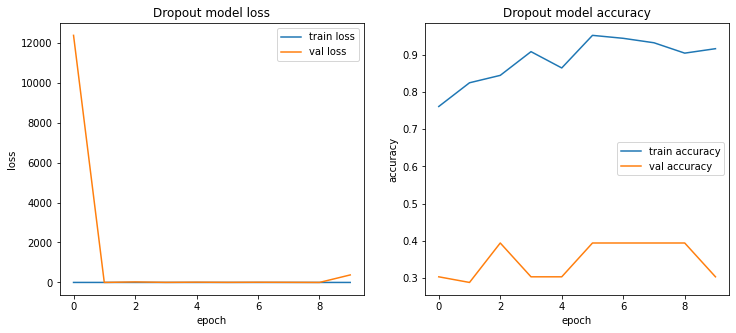

In [15]:
#plotting epoch vs loss and accuracy again
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), history.history['loss'], label='train loss')
plt.plot(range(10), history.history['val_loss'], label='val loss')
plt.title('Dropout model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(10), history.history['accuracy'], label='train accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='val accuracy')
plt.title('Dropout model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

As we can see our results are little improved after adding dropout, but the results are still not satisfied.
To further overcome the overfitting, we will use data augmentation technique and we retrained the model
and we got better results.

In [16]:

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:

img_width, img_height = 224, 224
batch_size = 8

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [18]:
x, y = next(train_generator)

In [19]:
x.shape

(8, 224, 224, 3)

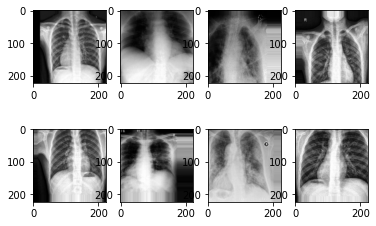

In [20]:
for i, j in zip(range(1,9), range(0,8)):
    plt.subplot(2, 4, i)
    plt.imshow(x[j])

In [21]:
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = tf.keras.layers.Dropout(rate=0.5)(global_avg_pooling) #added dropout
output = tf.keras.layers.Dense(3, activation='softmax')(dropout)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [22]:
history = model.fit(train_generator, epochs=60, validation_data=test_generator, verbose=1)

Epoch 1/60
32/32 [==============================] - 19s 433ms/step - loss: 1.4514 - accuracy: 0.3727 - val_loss: 1.6637 - val_accuracy: 0.3030
Epoch 2/60
32/32 [==============================] - 13s 406ms/step - loss: 0.9693 - accuracy: 0.5684 - val_loss: 1.4928 - val_accuracy: 0.3030
Epoch 3/60
32/32 [==============================] - 13s 400ms/step - loss: 0.8427 - accuracy: 0.6148 - val_loss: 1.5659 - val_accuracy: 0.3939
Epoch 4/60
32/32 [==============================] - 13s 392ms/step - loss: 0.6347 - accuracy: 0.7145 - val_loss: 1.7218 - val_accuracy: 0.3939
Epoch 5/60
32/32 [==============================] - 13s 419ms/step - loss: 0.5188 - accuracy: 0.7897 - val_loss: 1.7928 - val_accuracy: 0.3939
Epoch 6/60
32/32 [==============================] - 13s 406ms/step - loss: 0.4108 - accuracy: 0.8616 - val_loss: 1.9565 - val_accuracy: 0.3939
Epoch 7/60
32/32 [==============================] - 13s 426ms/step - loss: 0.3095 - accuracy: 0.9085 - val_loss: 2.0169 - val_accuracy: 0.3939

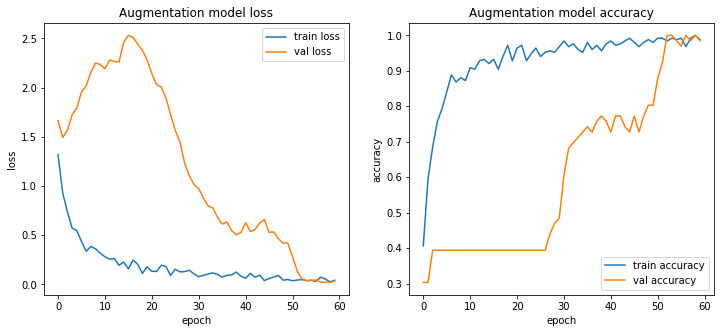

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(60), history.history['loss'], label='train loss')
plt.plot(range(60), history.history['val_loss'], label='val loss')
plt.title('Augmentation model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(60), history.history['accuracy'], label='train accuracy')
plt.plot(range(60), history.history['val_accuracy'], label='val accuracy')
plt.title('Augmentation model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

We increase size of epoch to 60 and results are improved.
Now we can check our model accuracy using different measures, but confusion matrix is the best technique for accuracy measure.


In [24]:
all_batches = []
count = 1
for batch in tqdm(test_generator):
    all_batches.append(batch)
    count = count + 1
    if count == 33:
        break

31it [00:04,  6.83it/s]                      


In [25]:
len(all_batches)

32

In [26]:
all_y_hats = []
all_y = []
for X, y in all_batches:
    y_hat = model.predict(X)
    y_hat = np.argmax(y_hat, 1)
    all_y_hats.extend(list(y_hat))
    all_y.extend(list(np.argmax(y, 1)))

Performance Measures

In [27]:
print(classification_report(all_y, all_y_hats))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      0.95      0.97        73
           2       0.95      1.00      0.97        72

    accuracy                           0.98       238
   macro avg       0.98      0.98      0.98       238
weighted avg       0.98      0.98      0.98       238



Confusion Matrix

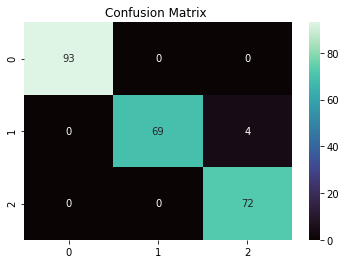

In [28]:
sns.heatmap(confusion_matrix(all_y, all_y_hats), annot=True, cmap='mako')
plt.title('Confusion Matrix ')
plt.show()

we have trained cnn model with Resnet and achieved 98% accuracy and by looking matrix we can conclude that all elements rather then diaognal are zero this shows that it is classified accurately.